# PSet 02: _the adventure of the hidden cloverleaf_


## Question 1:

Write Python code to read in the 100 aligned sequences, calculate mutual information between all pairs of columns i<j, and plot these results in the upper i<j triangle of an LxL (72x72) heat map.

In [1]:
import numpy as np                    
import matplotlib.pyplot as plt

%matplotlib inline 
np.set_printoptions(threshold=100)

In [2]:
def read_msa(file_name):
    """
    Parse a text file and extract the sequence names into a list and the sequences into a Numpy array called msa.
    The array has rows representing the different sequences (nseq=100) and columns representing the different positions within each sequence (L=72).
    Thus, msa[s][i] corresponds to position i in sequence s.
    The file is assumed to be in a format where each line contains a sequence name and the aligned DNA sequence in order, separated by whitespace(s).
    
    Parameters:
        file_name (str): The path to the text file.
    
    Returns:
        tuple: A tuple containing:
            - list: The sequence names (the first item in each line).
            - Numpy array: A 2D array with the DNA sequences (each letter in the sequence will be in a different entry in the array).
    """

    # Initialize the list of  and sequence names
    sequence_names = []
    sequences = []

    # Open the file to read
    with open(file_name, 'r') as file:
        # For every line in the file:
        for line in file:

            # Separate the line into elements separated by whitespaces. Append the first element (name) into the sequence_names list
            sequence_name = line.split()[0]
            sequence_names.append(sequence_name)

            # Append the second element (sequence) into the sequences list
            sequence = line.split()[1]
            sequences.append(list(sequence))

    # Make a numpy array from the list of lists of sequences to facilitate downstream manipulations
    msa = np.array(sequences)

    # Return the array containing the alignment and the list containing the sequence names
    return sequence_names, msa

# Use the read_msa function an copy the multiple sequence alignment into an object (msa) for downstream analysis
msa = read_msa('rna.msa')[1]

In [3]:
# Define a list of the nucleotides to check against later
alphabet = list('ACGT')


def make_probmx(alignment):
    """
    Calculate the singlet probability terms for each column in a multiple sequence alignment. The singlet probabilities correspond to 
    nucleotides A, C, G, and T in order, indexed 0 to 3 in the output array. The result is stored in an Lx4 numpy array `pmx`, such that each row 
    i represents column/position i in the input alignment from 0 to L-1, and each column represents the probabilities for nucleotides A, C, G, 
    and T, respectively. The singlet probabilities are obtained as frequencies by counting the occurrences of each nucleotide in a given column 
    and normalizing by the total number of sequences in that column.

    Parameters:
        alignment (numpy array): A 2D numpy array of shape NxL where N is the number of sequences and L is the length of the alignment. Each 
        entry in this array should be a nucleotide ('A', 'C', 'G', or 'T'). If this array contains anything else other than these 4 nucleotides,
        the function will print an error message and return None.

    Returns:
        numpy array: An Lx4 numpy array `pmx` containing the singlet probabilities for each column in the alignment. Rows correspond to 
        alignment columns, and columns 0 to 3 correspond to nucleotides A, C, G, and T, respectively.
    """
        
    #  Make sure all the letters in the input alignment are either A, C, G, or T. Otherwise print error message and return None.
    for sequence in alignment:
        for nucleotide in sequence:
            if nucleotide not in alphabet:
                print("Error: Invalid nucleotide found in the alignment. Only A, C, G, and T are allowed. Please check input format.")
                return None
    
    probs =[]

    # For every column in the alignemt (corresponding to for every row in the transpose of the alignment array):
    for column in alignment.T:
        letter_probs = []

        # Count how many letters in that column correspond to each of the 4 nucleotides and normalize each count by the column length
        for letter in alphabet:
            count = np.count_nonzero(column == letter)
            letter_probs.append(count/len(column))

        # Append the nucleotide frequences of that column to the probs list. This should be a list of lists (each corresponding to a different column)
        probs.append(letter_probs)

    # Take the list of lists containing the singlet probabilities for each column and make it into a 2D numpy array
    pmx = np.array(probs)

    # Return the 2D numpy array
    return pmx


In [4]:
def mutual_information(alignment):
    """
    Calculate the mutual information for all pairs of columns (i, j) in an input multiple sequence alignment.
    The mutual information between two columns i and j is calculated using the following forumula:

    Mij = ∑_a,b [pij(a,b) * log2(pij(a,b) / (pi(a) * pj(b)))]

    where:
    - pij(a, b) is the joint probability of observing nucleotide `a` in column `i` and nucleotide `b` in column `j`.
    - pi(a) is the singlet probability of observing nucleotide `a` in column `i`.
    - pj(b) is the singlet probability of observing nucleotide `b` in column `j`.
    Sum this up over all possible base pair combinations such that a and b are in the list of possible nucleotides 'alphabet'.
    Call the make_probmx() function to get the singlet probability terms needed for the calculation.
    Calculate the joint probabilities by collecting counts over all the sequences for any given columns i,j into a 4x4 matrix the normalizing this to
    frequencies.

    Parameters:
        alignment (numpy array): A 2D numpy array of shape NxL where N is the number of sequences and L is the length of the alignment. 
        Each entry in the array should be a nucleotide ('A', 'C', 'G', or 'T'). If this array contains anything else other than these 4 nucleotides,
        the function will print an error message and return None.

    Returns:
        numpy array: An LxL numpy array `M_inf`, where each element `M_inf[i, j]` contains the mutual information between 
        column `i` and column `j` for all i < j. The lower triangle (i > j) of the matrix will thus only consist of zeros because mutual information 
        is symmetric.
    """
    
    # Define L as the number of columns/positions in the multiple sequence alignment
    L = alignment.shape[1]
    
    # Make sure all the letters in the input alignment are either A, C, G, or T. Otherwise print error message and return None.
    for sequence in alignment:
        for nucleotide in sequence:
            if nucleotide not in alphabet:
                print("Error: Invalid nucleotide found in the alignment. Only A, C, G, and T are allowed. Please check input format.")
                return None
                
    # Initialize the mutual information matrix
    M_inf = np.zeros((L,L)) 

    # Map nucleotide characters to indices using a dictionary
    alphabet_keys = {'A': 0, 'C': 1, 'G': 2, 'T': 3}  

    # Calculate the singlet probability terms using make_probmx
    pmx = make_probmx(alignment)

    # Obtain a joint probabilites matrix and calculate mutual information for each pair of columns i and j such that i < j
    for i in range(L):
        
        # Restrict the calculation to only consider pairs where i < j
        for j in range(i+1, L):  

            # Initialize a 4x4 matrix for the joint probabilities of that specific (i,j) pair of columns
            pair_probs = np.zeros((4,4))  

            # Count occurrences of all the nucleotide pair combinations by iterating across all sequences for that (i,j) pair.
            for sequence in alignment:
                letter_i = alphabet_keys[sequence[i]] # Use the alphabet_keys dictionary to get an index corresponding to each letter
                letter_j = alphabet_keys[sequence[j]]
                pair_probs[letter_i][letter_j] += 1 # Increase count by 1 for that specific letter combination in the joint probabilities matrix of this pair

            pair_probs /= len(alignment)  # Normalize the counts by the total number of sequences to obtain probabilities

            # Calculate the mutual information the pair of columns (i,j)
            M_ij = 0

            # Iterate through all possible combinations of base pairs in a nested loop
            for a in range(4):
                for b in range(4):

                    # Extract singlet probabilities
                    pi_a = pmx[i][a]
                    pj_b = pmx[j][b]

                    # Only do the calculation if all probabilities are nonzero (if they are zero, the calculation would result in mathematical errors)
                    if (pair_probs[a][b] > 0) and (pi_a > 0) and (pj_b > 0):
                        
                        # Use the formula to compute the mutual information for pair (i,j)
                        M_ij += pair_probs[a][b] * np.log2(pair_probs[a][b] / (pi_a * pj_b))
            
            # Store the mutual information for columns (i,j) in the mutual information matrix
            M_inf[i][j] = M_ij

    return M_inf

# Use the function to get the mutual information of our alignment
M = mutual_information(msa)

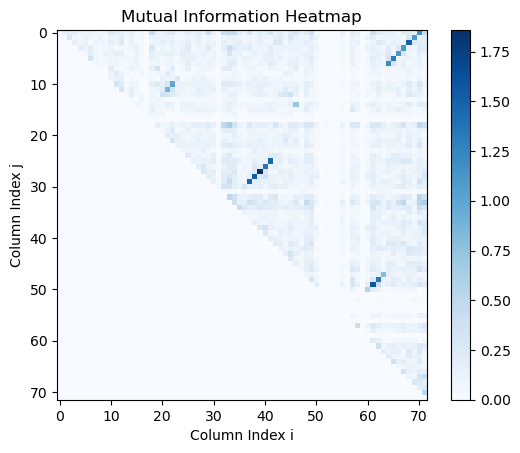

In [5]:
# Plot on a heatmap

# Choose a sequential color map
cmap = 'Blues'  

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the heatmap using imshow
cax = ax.imshow(M, cmap=cmap, vmin=M.min(), vmax=M.max())

# Add color bar
fig.colorbar(cax)

# Set labels and title
ax.set_title('Mutual Information Heatmap')
ax.set_xlabel('Column Index i')
ax.set_ylabel('Column Index j')

# Show the plot
plt.show()

## Question 2:

Explain the main features you see in this plot. Do you see evidence for the tRNA cloverleaf? What are some other things or patterns you see?

Yes, there is some evidence for a tRNA cloverleaf. There is 4 stretches of high mutual information that visually stand out against the background level. These stretches have indices that correspond to the consensus tRNA base pairs list provided by Wiggins
(the 7bp acceptor stem from (0, 70) to (6,64), the 4bp D stem from (9,23) to (12,20), the 5bp anticodon stem from (25,41) to (29, 37), and the 5bp T stem from (47,63) to (51,59)). 

The map shows much lower mutual information levels on average outside of these 4 stretches, indicating a lack of covariation-inducing selective pressure which means they are unlikely to be base pairing stretches outside of these 4. 

Other pattern that clearly shows up in the heatmap is a mutual information level very close to 0 around the indices i = 52 to i = 58 which corresponds to the $T \psi C$ loop. This makes sense because this region actually acts as a special recognition site for the ribosome to form a tRNA-ribosome complex during protein biosynthesis (functionally important) which likely means its sequence is strongly conserved to allow for this recognition. A strongly conserved region is expected to have 0 mutual information with any other column because as they vary, it does not and remains conserved. This explains the band of very low mutual information in that region.


## Question 3:

Devise a "null hypothesis" and write code to produce an alignment with the same primary sequence conservation statistics as the original MSA, but where pairwise correlations have been randomized.




My null hypothesis is:
The observed stretches of high mutual information in the mutual information heatmap can be attributed to random chance and do not indicate the presence of a tRNA overleaf structure.

To test this hypothesis, I will produce a set of many randomized multiple sequence alignments where the primary sequence conservation statistics are conserved (that is, the singlet probabilties, pi(a) at each position are the same as the original alignment) but the pairwise correlations have been randomized (that is, the pij's are now "independent". I will do this using a shuffling approach. I chose shuffling over sampling with repetition because it results in exact overall column-wise conservation such as GC content and residue frequencies. By shuffling the nucleotides separately within each column of the MSA, you break any existing pairwise correlations between the columns but maintain the sequence composition of the individual columns.


In [6]:
# Shuffle columns

def shuffle_msa(alignment):
    """
    Shuffle the nucleotides within the columns of a multiple sequence alignment while preserving the nucleotide composition within each column. This method randomizes pairwise
    correlations between columns while maintaining the singlet probabilities (i.e., the residue frequencies) at each position by shuffling the nucleotides
    within each column. 
    
    Parameters:
    alignment (numpy.ndarray): A 2D numpy array where each row corresponds to a sequence and each column represents a position in the alignment.

    Returns:
    numpy.ndarray: The shuffled MSA with the same column-wise composition but randomized pairwise correlations between columns.
    """
    # Create a numpy random number generator object
    rng = np.random.default_rng() 

    # Make a copy of the alignment to use to create the shuffled alignment
    shuffled_msa = alignment.copy()

    # For eah column in the alignment:
    for col in range(shuffled_msa.shape[1]):

        # Shuffle the nucleotides within this column across the different sequences
        rng.shuffle(shuffled_msa[:,col])

    # Return the shuffled alignment
    return shuffled_msa


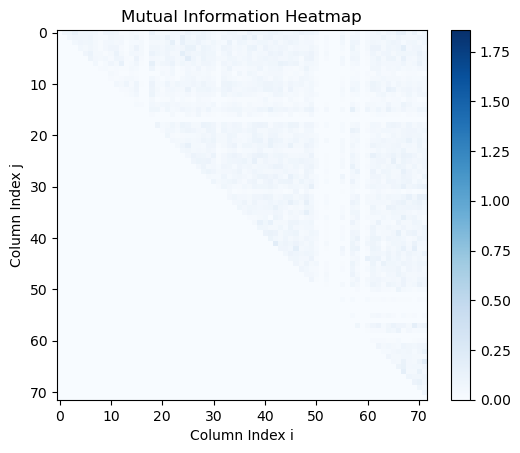

In [7]:
# This chunk is just to check whether my shuffle function works to produce negative control alignments

# Create a toy mutual information from a shuffled/randomized negative control alignment
shuffled = shuffle_msa(msa)
toy_M = mutual_information(shuffled)

# Plot shuffled mutual information matrix on a heatmap

# Sequential colormap
cmap = 'Blues'  

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot the heatmap using imshow
cax = ax.imshow(toy_M, cmap=cmap, vmin=M.min(), vmax=M.max())

# Add color bar
fig.colorbar(cax)

# Set labels and title
ax.set_title('Mutual Information Heatmap')
ax.set_xlabel('Column Index i')
ax.set_ylabel('Column Index j')

# Show the plot
plt.show()

As expected, the shuffle function breaks the pairwise correlations between the different columns and the mutual information heatmap of the shuffled alignment just shows the background level mutual information (noise) compared to the heatmap of the actual alignment.

## Question 4:
Produce a set of many randomized MSAs and calculate mutual information values from them. Plot the distribution P(Mij>t)versus varying threshold t for these negative control data -- a so-called complementary cumulative distribution function, also known as a survival function. Also plot the distribution of the Mij values from the actual rna.msa alignment. (There are 2556 of them: (L(L-1)/2).) Justify a choice of threshold t for calling an Mij mutual information "significant".

In [8]:
# Produce a set of many randomized MSAs and calculate the mutual information values from them

# Initialize the mutual information array of the shuffled MSAs (there will be 100 mutual information matrices of dimensions 72x72)
M_sh = np.zeros((100,72,72))

# Obtain 100 shuffled MSAs using the shuffle_msa function, calculate their mutual information matrix, and store them within M_sh
for sample in range(100):
    shuffled = shuffle_msa(msa)
    M_sh[sample] = mutual_information(shuffled)


# Extract upper triangle of each M_ij in order to avoid the artificial zeros in the lower triangle 
    #(see above about how mutual information is symmetric so the calculation was only done for i<j and the rest are artificially 0)

    # Use the triu_indices function to extract the indices of the values that are in the upper triangle. k=1 means exclude the 0th diagonal since it also contains artificial 0s
    # Extract only values of those indices for both the mutual information matrix of the actual alignment and of all 100 of the shuffled alignments
M_upper = M[np.triu_indices(M.shape[0], k=1)]
M_sh_upper = [M_sh[i][np.triu_indices(M_sh[i].shape[0], k=1)] for i in range(100)] # List comprehension method to execute this on a 3D matrix
M_sh_upper = np.array(M_sh_upper) # Make sure output of the list comprehension is a numpy array

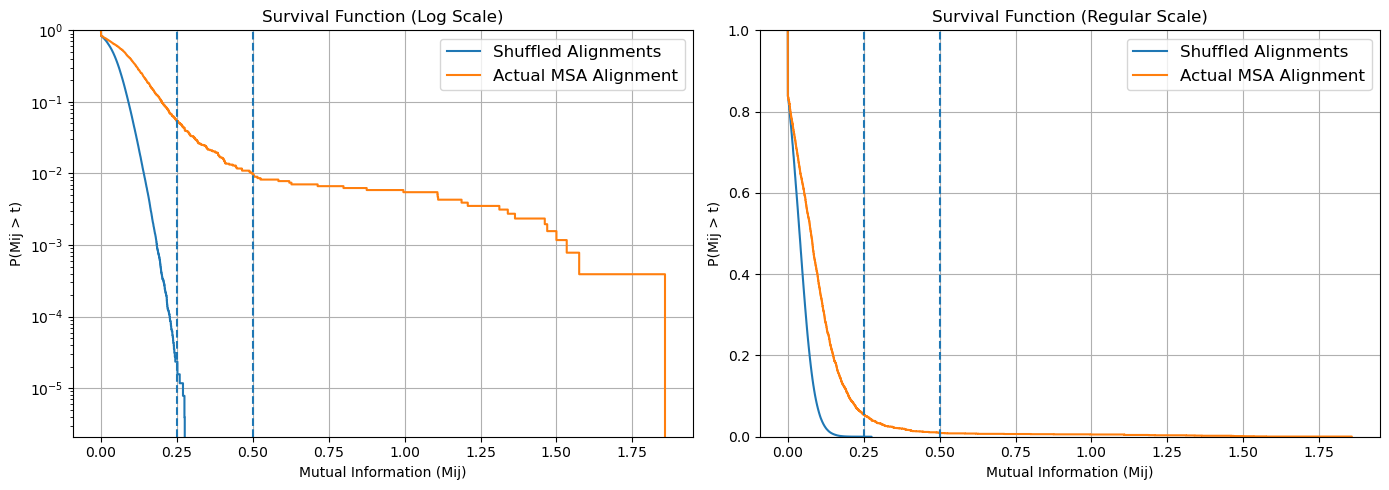

In [9]:
# Plot the survival functions (distribution of P(Mij >t)) to choose a threshold:


# Create figure and axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot survival function on log scale (left subplot)
    # Flatten() is used to aggregate a 2D numpy array into a 1D one so we can plot the survival functions for all the values aggregated
    # Use ecdf() with complementary=True to obtain a survival function (also known as a complementary cumulative distribution function)
ax1.ecdf(M_sh_upper.flatten(), complementary=True, label='Shuffled Alignments')
ax1.ecdf(M_upper, complementary=True, label='Actual MSA Alignment')

# Axis labels
ax1.set_xlabel('Mutual Information (Mij)')
ax1.set_ylabel('P(Mij > t)')

# Log scale on the y-axis
ax1.set_yscale('log')

# Set title
ax1.set_title('Survival Function (Log Scale)')

# Show a grid
ax1.grid(True)

#Indicate chosen thresholds
ax1.axvline(x=0.25, linestyle='--')
ax1.axvline(x=0.50, linestyle='--')
ax1.legend(loc='upper right', fontsize=12)

# Plot survival function on regular scale (right subplot)
ax2.ecdf(M_sh_upper.flatten(), complementary=True, label='Shuffled Alignments')
ax2.ecdf(M_upper, complementary=True, label='Actual MSA Alignment')

# Axis labels
ax2.set_xlabel('Mutual Information (Mij)')
ax2.set_ylabel('P(Mij > t)')

# Set title
ax2.set_title('Survival Function (Regular Scale)')

# Show a grid
ax2.grid(True)

# Indicate chosen thresholds
ax2.axvline(x=0.25, linestyle='--')
ax2.axvline(x=0.50, linestyle='--')
ax2.legend(loc='upper right', fontsize=12)

# Show both plots
plt.tight_layout()
plt.show()



As expected, the survival functions show that the shuffled/randomized alignments (in blue) have overall lower mutual information values than the actual alignment (in orange).

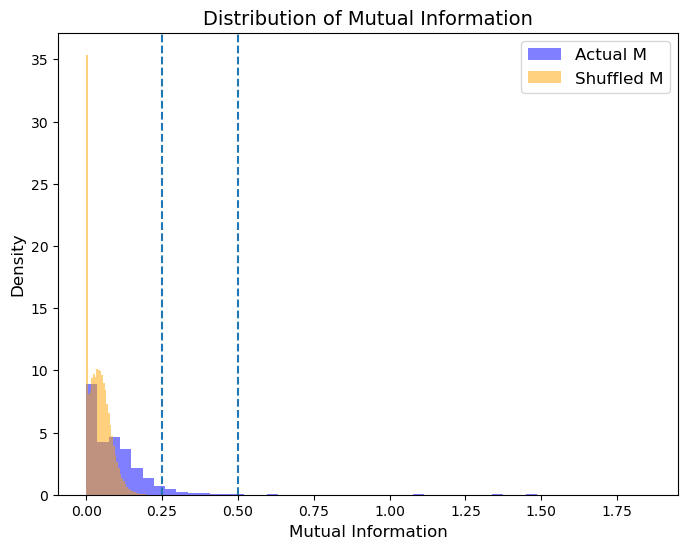

In [10]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram for the actual mutual information
ax.hist(M_upper, bins=50, alpha=0.5, density=True, label='Actual M', color='blue')

# Plot histogram for the shuffled mutual informations recursively (on top of each other)
ax.hist(M_sh_upper.flatten(), bins=50, alpha=0.5, density=True, label='Shuffled M', color='orange')
 
# Set axis labels
ax.set_xlabel('Mutual Information', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

# Indicate chosen thresholds
ax.axvline(x=0.25, linestyle='--')
ax.axvline(x=0.50, linestyle='--')

# Add title and legend 
ax.set_title('Distribution of Mutual Information', fontsize=14)
ax.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()


As expected, the shuffled alignments' mutual information tends to be lower on average and more right-skewed than that of the actual alignment which makes sense since the actual alignment carries signal of co-evolution, base pairing, and tertiary structure that increases the mutual information which the shuffled alignments do not carry.

Based on survival function plots and the density plots above, I am choosing 2 thresholds to call an Mij mutual information significant: one that is quite permissive and one that is more conservative. 
- My permissive threhsold is 0.25 just because it looks like the vast majority of the density of the shuffled alignments is less this threshold so it seems there will be not many false positives at after this threshold.
- My conservative threshold is 0.5 because that both avoids the density of the shuffled alignments which represent false positives based on my hypothesis, and provides slightly more stringency on "significance". This is because we do expect for there to be some amout of biological/evolutionary noise in our acutal alignment because our assumption that the positions are "independent" is actually incorrect as they are linked evolutionarily. To avoid capturing some of that noise that would not be reflected in our shuffled alignments or null hypothesis (as well as other noise that way result from teritary structures and the like), and to try and capture as much real signal as possible resulting from base pairing. A higher threshold such as 0.5 may be more fitting.

## Question 5:

Extract a list of all the putative consensus base pairs that satisfy your threshold. Compare your list to the list of consensus base pairs expected for tRNA. How many of the expected base pairs are supported by your mutual information analysis? If you see support for other pairs, give a possible explanation for them.

The mutual information coordinates that exceed 0.25 are: 
 [[ 0 18]
 [ 0 29]
 [ 0 32]
 ...
 [67 71]
 [68 69]
 [70 71]]
There are 140 base pairs that satisfy this threshold: 0.25
Consensus tRNA base pairs missing from list :(51, 59)


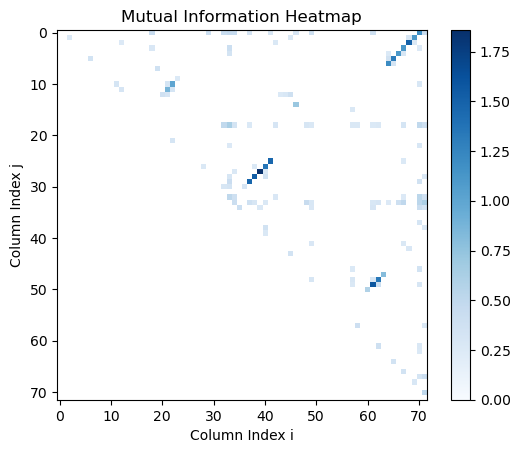

The mutual information coordinates that exceed 0.5 are: 
 [[ 0 70]
 [ 1 69]
 [ 2 68]
 [ 3 67]
 [ 4 66]
 [ 5 65]
 [ 6 64]
 [10 22]
 [11 21]
 [14 46]
 [18 33]
 [25 41]
 [26 40]
 [27 39]
 [28 38]
 [29 37]
 [32 33]
 [32 70]
 [33 70]
 [33 71]
 [47 63]
 [48 62]
 [49 61]
 [50 60]
 [70 71]]
There are 25 base pairs that satisfy this threshold: 0.5
Consensus tRNA base pairs missing from list : (9, 23)
Consensus tRNA base pairs missing from list : (12, 20)
Consensus tRNA base pairs missing from list : (51, 59)


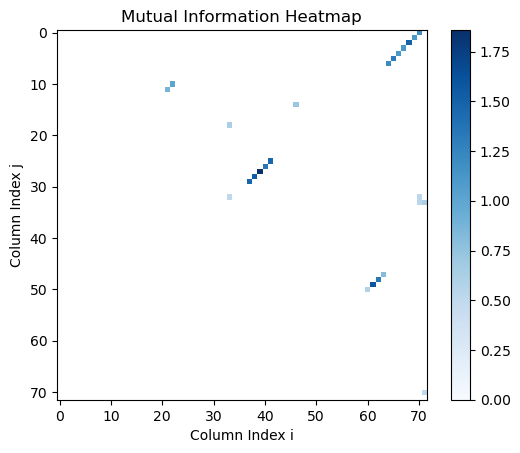

In [15]:
# Consensus tRNA base pairs:

bp_list = [  (0, 70),  (1, 69),  (2, 68),  (3, 67),  (4, 66), (5, 65), (6, 64),   # 7bp acceptor stem
             (9, 23), (10, 22), (11, 21), (12, 20),                               # 4bp D stem
            (25, 41), (26, 40), (27, 39), (28, 38), (29, 37),                     # 5bp anticodon stem
            (47, 63), (48, 62), (49, 61), (50, 60), (51, 59) ]                    # 5bp T stem;  




# Extract list above threshold

# Let threshold be 0.25:
threshold = 0.25 
# Extract coordinates of mutual informations above this threshold:
coordinates = np.argwhere(M> threshold)

# Print the coordiantes and how many of them there are
# Ensure threshold is converted to a string if needed
    #Use f-string formatting
print(f"The mutual information coordinates that exceed {threshold} are: \n {coordinates}")
print(f"There are {coordinates.shape[0]} base pairs that satisfy this threshold: {threshold}")


# Print which consensus tRNA base pairs are missing from the list of base pairs that satisfy this threshold
for bp in bp_list:
    if bp not in coordinates:
        print(f"Consensus tRNA base pairs missing from list :{bp}")


# Make a thresholded matrix for the thresholded heatmap
M_thresholded_25 = np.where(M > threshold, M, np.nan)

# Thresholded heatmap to visualize which base pairs exceed the threshold

# Sequential colormap
map = 'Blues'  

# Create axes and figure objects
fig, ax = plt.subplots()

# Plot the heatmap using imshow
cax = ax.imshow(M_thresholded_25, cmap=cmap, vmin=M.min(), vmax=M.max())

# Add color bar
fig.colorbar(cax)

# Set labels and title
ax.set_title('Mutual Information Heatmap')
ax.set_xlabel('Column Index i')
ax.set_ylabel('Column Index j')

# Show the plot
plt.show()


# Now, let threshold be 0.50
threshold = 0.5

# Extract coordinates of mutual informations above this threshold:
coordinates = np.argwhere(M > threshold)

# Print the coordiantes and how many of them there are
# Ensure threshold is converted to a string if needed
    #Use f-string formatting
print(f"The mutual information coordinates that exceed {threshold} are: \n {coordinates}")
print(f"There are {coordinates.shape[0]} base pairs that satisfy this threshold: {threshold}")


# Print which consensus tRNA base pairs are missing from the list of base pairs that satisfy this threshold
for bp in bp_list:
    if bp not in coordinates:
        print(f"Consensus tRNA base pairs missing from list : {bp}")

# Make a thresholded matrix for the thresholded heatmap
M_thresholded_50 = np.where(M > threshold, M, np.nan)

# Thresholded heatmap to visualize which base pairs exceed the threshold

# Sequential colormap
map = 'Blues'  

# Create axes and figure objects
fig, ax = plt.subplots()

# Plot the heatmap using imshow
cax = ax.imshow(M_thresholded_50, cmap=cmap, vmin=M.min(), vmax=M.max())

# Add color bar
fig.colorbar(cax)

# Set labels and title
ax.set_title('Mutual Information Heatmap')
ax.set_xlabel('Column Index i')
ax.set_ylabel('Column Index j')

# Show the plot
plt.show()

Most of the expected base pairs from the consensus tRNA base pairs list that Wiggins provided are supported by my analysis, using the 0.25 permissive threshold to define significance. The only exception is (51, 59). But because this threshold is so permissive, many (120 to be exact) other base pairs that not on this list are supported as "significant" by this threshold. The heatmap shows this well. This is likely beause a) the threshold is lenient and will capture a certain (albeit presumably small) number of false positives and b) because there is other biological noise that was captured in the actual/initial multiple sequence alignment that is not reflecting base pairing but that is inflating the mutual information values. This biological noise is not captured captured in our negative control "shuffled" alignments so we have to be careful when using that distribution to define a threshold for significance because our null hypothesis not very strong. Just because a high mutual information value is not due to random chance (which is what our test of shuffling measures) does not mean that it is truly indicative of base pairing (our alternative hypothesis). In other words, just because we reject our null hypothesis, does not mean the alternative hypothesis is necessarily true. The biological noise that may be captured instead can include the co-evolution of the sequences (after all they are all phages that have a common ancestor) which opposed our "independence" assumptions, the formation of tertiary structures or other sorts of structures or domains or the binding of two positions to a different molecule, etc. 

The more conservative threshold that we shows is much better at eliminating that biological noise at the cost of potentially not capturing all of the desired consensus tRNA base pairs (3 missing) but still capturing most of them (18 present). There is still some noise remaining but there is much less noise captured at this more stringent threshold (only 7 of the base pairs that satisfy this threshold are not identified as tRNA consensus base pairs) the permissive. Thus, a more stringent threshold can help us weed through some of the biological noise mentioned above, at the cost of losing a couple true signal base pairs.

## Question 6:

Does the mutual information analysis support Wiggins' hypothesis
that this conserved region encodes a tRNA?

Overall, the mutual information analysis that we did does support Wiggins' hypothesis that this conserved region encodes a tRNA but further analyses remain to be done to make sure that this is the case. As mentioned, just because a high mutual information value is not due to random chance (which is what our test of shuffling measures) does not mean that it is truly indicative of base pairing (our alternative hypothesis). Just because we reject our null hypothesis, does not mean the alternative hypothesis is necessarily true. It is true that even the stringent threshold that we chose (0.5) support the tRNA strcuture hypothesis (most of the consensus tRNA base pairs are deemed to be significant at that threshold and not much noise is present) which is a good sign that this is the right answer but a better and smarter way to do this to get a more confident answer and be more sure of Wiggins' hypothesis is to design a stronger null hypothesis and create negative control sequences that can capture some of the biological noise mentioned above (co-evolution, etc.) so we can eliminate it when running the test.

In [12]:
import watermark 
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab


Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.2.5

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

